In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

import numpy, scipy
import librosa

from scipy import signal
from scipy.io import wavfile

In [ ]:
# load the drive helper and mount###
from google.colab import drive

# this will prompt for authorization.
drive.mount('/content/drive')

# after executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

data_dir = pathlib.Path('/content/drive/MyDrive/new_voice')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'  'gg ss.JPG'	        voice
 conv_audio	   'models & weights'  'Voice Controlled Led'
 Data		    new_voice	       'voice robot'
 dataset	    Others	       'Voice Robot raw'
 dataset_new	   'Pics new'	       'yt ss.JPG'
'ff ss.JPG'	    video


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['on' 'off' 'green' 'red']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 80
Number of examples per label: 20
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/new_voice/red/Recording_41.wav', shape=(), dtype=string)


**Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.**

In [ ]:
train_files = filenames[:64]
val_files = filenames[64:72]
test_files = filenames[72:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 64
Validation set size 8
Test set size 8


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

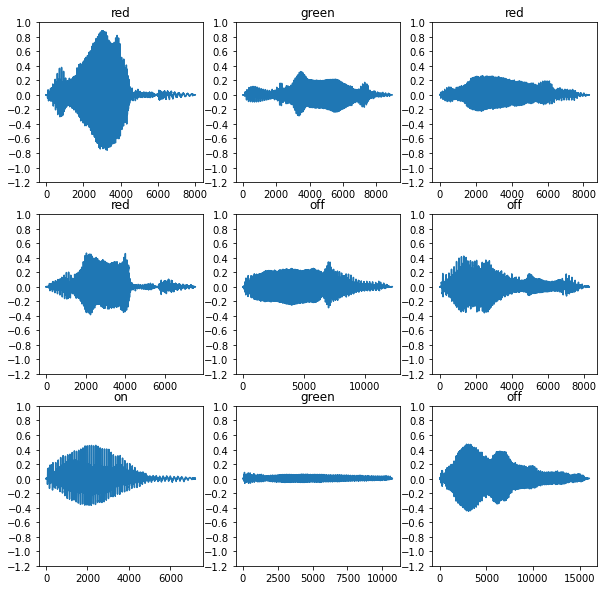

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def stft(x):
    f, t, spec = signal.stft(x.numpy(), fs=22050, nperseg=255, noverlap = 124, nfft=256)
    return tf.convert_to_tensor(np.abs(spec))

In [ ]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([22050] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
    
  spectrogram = tf.py_function(func=stft, inp=[equal_length], Tout=tf.float32)
       
  spectrogram.set_shape((129, 170))
  
  return spectrogram

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

### **Build and Train the model**

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [ ]:
batch_size = 1
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (129, 170, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 5
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
64/64 [==============================] - 2s 27ms/step - loss: 1.3964 - accuracy: 0.3438 - val_loss: 1.0622 - val_accuracy: 0.8750
Epoch 2/5
64/64 [==============================] - 1s 19ms/step - loss: 0.7297 - accuracy: 0.7031 - val_loss: 0.4353 - val_accuracy: 0.7500
Epoch 3/5
64/64 [==============================] - 1s 14ms/step - loss: 0.4784 - accuracy: 0.8594 - val_loss: 0.1963 - val_accuracy: 0.8750
Epoch 4/5
64/64 [==============================] - 1s 21ms/step - loss: 0.2946 - accuracy: 0.9219 - val_loss: 0.0751 - val_accuracy: 1.0000
Epoch 5/5
64/64 [==============================] - 1s 18ms/step - loss: 0.2378 - accuracy: 0.9062 - val_loss: 0.0981 - val_accuracy: 1.0000


**Loss Graph**

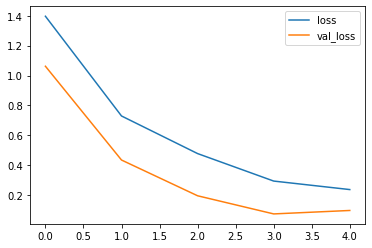

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**Accuracy Graph**

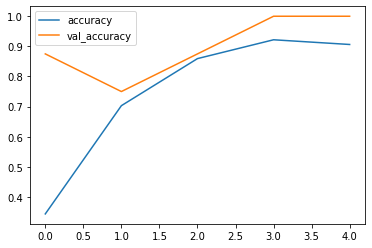

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

**Model Saving and Size Check**

In [ ]:
model.save ("tf_audio_27mar.h5")
print ('TF Size:', round(os.path.getsize("tf_audio_27mar.h5")/(1024*1024), 3) , 'MB')

TF Size: 18.646 MB


### **Test Set Accuracy Check**

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


**Display a confusion matrix**

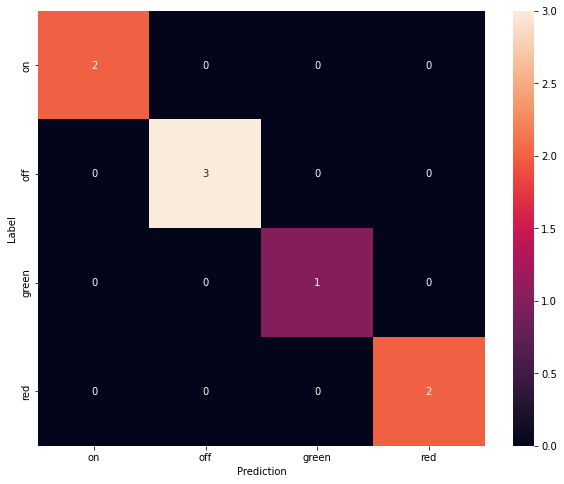

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### **Model Prediction**

Finally, verify the model's prediction output using an input audio file. How well does your model perform?

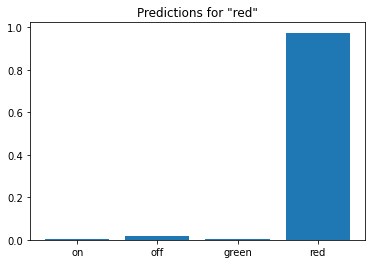

In [ ]:
sample_file = data_dir/'red/Recording_23.wav' # use any file here

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

# **TF Lite Started**


**TF Model to TF Lite Conversion**

In [ ]:
# convert & optimize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimization = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp77peg0w6/assets


**TF Lite Model Saving & Size Check**

In [ ]:
# save the model
open('tflite_audio_27mar.tflite', 'wb').write(tflite_model)

# model size check
print ('TF Lite Size:', round(os.path.getsize('tflite_audio_27mar.tflite')/(1024), 3) , 'KB')

TF Lite Size: 6351.109 KB


**Interpreter**

In [ ]:
# 'interpreter' to interpret tf lite model and to get input & output details
# models obtained from 'TfLiteConverter' can be run in python with 'interpreter'
interpreter = tf.lite.Interpreter('tflite_audio_27mar.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print input & output values & shapes to check everything is same 
# as the orignal tf model.
# data types etc are changed during tf lite conversion & optimizations
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 129 170   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


**Comparison of TF & TF Lite Output**

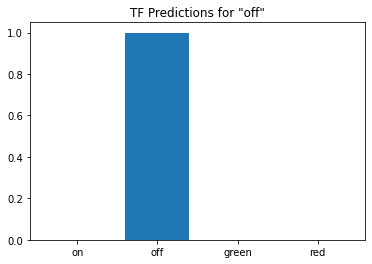

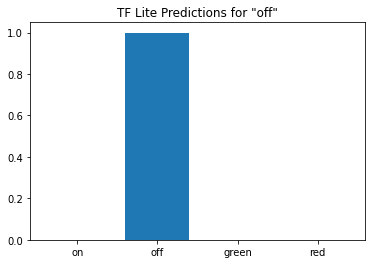

In [ ]:
sample_file = data_dir/'off/Recording_19.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'TF Predictions for "{commands[label[0]]}"')
  plt.show()

for spectrogram, label in sample_ds.batch(1):
  # needed before execution
  # tensorFlow lite pre-plans tensor allocations to optimize inference,
  # so the user needs to call allocate_tensors() before any inference.
  interpreter.allocate_tensors()
  interpreter.set_tensor(input_details[0]['index'],spectrogram)
  interpreter.invoke()

  # predicting from tf lite model
  predictionx = interpreter.get_tensor(output_details[0]['index'])
  plt.bar(commands, tf.nn.softmax(predictionx[0]))
  plt.title(f'TF Lite Predictions for "{commands[label[0]]}"')
  plt.show()
